In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, DataLoader

# from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [110]:
# set metal backend (apple chips)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

## Using grid-interpolated dataset:

Autoencoders use image data, so we need to use image datasets.

In [2]:
root = Path.cwd().parents[0]
data = root/'data'/'interpolation_datasets'/'rec-interpolation2.nc'
ds = xr.open_dataset(data)
ds

<xarray.Dataset>
Dimensions:        (y: 707, x: 200, P: 8, V: 4)
Coordinates:
  * y              (y) float64 0.0 0.001 0.002 0.003 ... 0.703 0.704 0.705 0.706
  * x              (x) float64 0.0 0.001 0.002 0.003 ... 0.196 0.197 0.198 0.199
  * P              (P) float64 5.0 10.0 30.0 45.0 60.0 80.0 100.0 120.0
  * V              (V) float64 200.0 300.0 400.0 500.0
Data variables:
    potential (V)  (V, P, y, x) float64 ...
    Ne (#/m^-3)    (V, P, y, x) float64 ...
    Ar+ (#/m^-3)   (V, P, y, x) float64 ...
    Nm (#/m^-3)    (V, P, y, x) float64 ...
    Te (eV)        (V, P, y, x) float64 ...

In [3]:
vars = list(ds.data_vars)
vars

['potential (V)', 'Ne (#/m^-3)', 'Ar+ (#/m^-3)', 'Nm (#/m^-3)', 'Te (eV)']

In [4]:
scaler_dict = {}

In [5]:
def scale_np(array, var):
    global scaler_dict
    
    max = np.nanmax(array)
    min = np.nanmin(array) 

    scaler_dict[var] = (min, max)

    return (array - min) / (max - min)

In [114]:
data = np.float32(np.nan_to_num(np.stack([scale_np(ds[var].values, var) for var in vars])))
print(data.shape)
print(scaler_dict)

(5, 4, 8, 707, 200)
{'potential (V)': (-7.395783985231219e-16, 205.71708513606058), 'Ne (#/m^-3)': (3.071652512709689e-11, 1.6756994097021318e+16), 'Ar+ (#/m^-3)': (77385728216.21078, 1.675769409702132e+16), 'Nm (#/m^-3)': (10794684467551.668, 8.549053831954201e+18), 'Te (eV)': (0.049999999999999545, 11.672450000000012)}


Shuffle dimensions and combine V, P. 

Output shape should follow `(batch, height, width, channels)`

In [115]:
data = np.moveaxis(data, 0, 4)
data = data.reshape(32,707,200,5)
data = np.moveaxis(data, 3, 1)
data.shape

(32, 5, 707, 200)

Train test split

In [116]:
train, test = train_test_split(data, test_size = 1/32, shuffle=True)
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (31, 5, 707, 200)
test shape: (1, 5, 707, 200)


In [118]:
dataset = TensorDataset(torch.tensor(train, device=device))
trainloader = DataLoader(dataset, batch_size=1, shuffle=True)

Visualize one set of inputs

In [14]:
import matplotlib.patches as pat
import matplotlib.pyplot as plt
def draw_apparatus(ax):
    def edge_unit_conv(edges):
        u = 1e-1 # unit conv. mm -> cm
        return [(xy[0]*u,xy[1]*u) for xy in edges]
    
    pt_colors = {'fc':'white', 'ec':'black'}
    
    edges = [(0,453), (0,489), (95,489), (95,487), (40,487), (40,453)]
    patch_top = pat.Polygon(xy=edge_unit_conv(edges), fc=pt_colors['fc'], ec=pt_colors['ec'])
    ax.add_patch(patch_top)
    
    edges = [(0,0), (0,415), (95,415), (95,395), (90,395), (90,310), (120,310), (120,277), (90,277), (90,0)]
    patch_bottom = pat.Polygon(xy=edge_unit_conv(edges), fc=pt_colors['fc'], ec=pt_colors['ec'])
    ax.add_patch(patch_bottom)
    
    edges = [(122,224), (122,234), (185,234), (185,224)]
    patch_float = pat.Polygon(xy=edge_unit_conv(edges), fc=pt_colors['fc'], ec=pt_colors['ec'])
    ax.add_patch(patch_float)

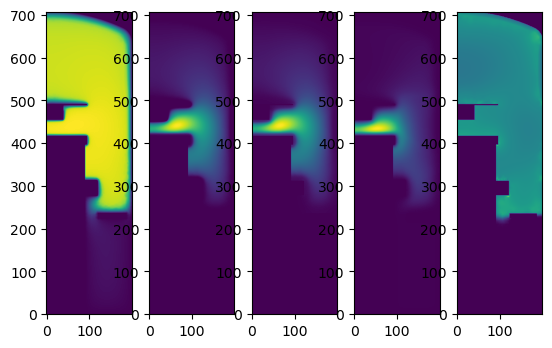

In [119]:
fig, axs = plt.subplots(nrows=1, ncols=5)
for i, ax in enumerate(axs):
    ax.imshow(test[0,i,:,:], origin='lower')

## Define a model

In [121]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(5, 16, kernel_size=3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
      nn.ReLU()
    )

    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(8, 16, 3, 2),
      nn.ConvTranspose2d(16, 8, 3, 2),
      nn.Conv2d(8, 5, 3, padding=1)
    )
    

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    decoded = torchvision.transforms.functional.crop(decoded, 0, 0, 707, 200) 
    return decoded

In [123]:
model = Autoencoder()
model.to(device)  # move model to gpu
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [93]:
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(5, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (2): Conv2d(8, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


In [137]:
epochs = 200

In [138]:
for epoch in tqdm(range(epochs)):
    # loop = tqdm(trainloader)

    for i, batch_data in enumerate(trainloader):
        # get inputs
        inputs = batch_data[0]
        optimizer.zero_grad()

        # record loss
        running_loss = 0.0

        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # loop.set_description(f"Epoch {epoch+1}/{epochs}")
        running_loss = 0.0
    


  0%|          | 0/200 [00:00<?, ?it/s]

In [90]:
outputs.size()

torch.Size([1, 5, 711, 203])

In [132]:
test_tensor = torch.tensor(test, device=device)

In [133]:
with torch.no_grad():
    encoded = model.encoder(test_tensor)
    decoded = model.decoder(encoded).cpu().numpy()

In [134]:
decoded.shape

(1, 5, 711, 203)

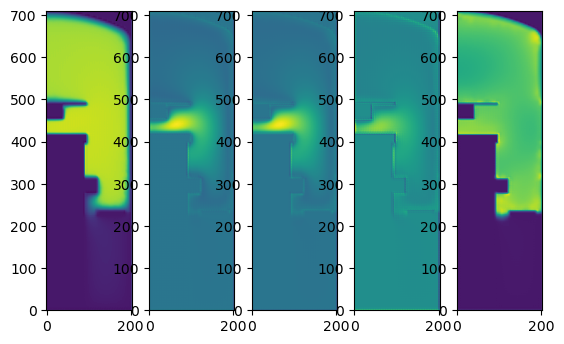

In [135]:
fig, axs = plt.subplots(nrows=1, ncols=5)
for i, ax in enumerate(axs):
    ax.imshow(decoded[0,i,:,:], origin='lower')
    ax.colormap